In [1]:
#Dependencies
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier


In [2]:
#load in datasets
matches = pd.read_csv("Resources/epl_matches_combined.csv", index_col=0) 
matches.head()


,venue_code,opp_code,hour,day_code,team_code,season,round,date,time,day,...,last_3_ga_2,last_3_avg_poss_2,last_3_avg_sot_2,opp_last_3_gd,last_3_gd_diff,last_3_avg_poss_diff,last_3_avg_sot_diff,last_3_results_diff,target,target_2
0,0,26,14,6,1,2024,29,2024-03-17,14:00,Sun,...,9.0,46.000000,5.000000,-4.0,3.0,2.000000,0.000000,-1.0,-1.0,0.0
1,1,1,14,6,26,2024,29,2024-03-17,14:00,Sun,...,7.0,48.000000,5.000000,1.0,3.0,-2.000000,0.000000,0.0,-1.0,0.0
2,1,23,17,5,10,2024,29,2024-03-16,17:30,Sat,...,8.0,72.333333,5.000000,-5.0,8.0,-30.666667,0.333333,0.0,1.0,-1.0
3,1,3,15,5,5,2024,29,2024-03-16,15:00,Sat,...,5.0,40.333333,5.333333,3.0,-8.0,15.000000,-2.333333,-1.0,1.0,-1.0
4,0,15,15,5,20,2024,29,2024-03-16,15:00,Sat,...,4.0,45.666667,3.000000,4.0,-8.0,-9.000000,0.000000,-1.0,-1.0,0.0


In [3]:
# Define the list of features that we want to include in our model. This will be used as the X values. 
#Features can be added or removed to see how it affects the model.

# Define the list of predictors including venue code, opponent code, hour, and day code.
predictors = ['venue_code', 'opp_code', 'hour', 'day_code','team_code','last_3_results','last_3_results_2', 'xg', 'xga', 'xg_2', 'xga_2' ]
            
# Team 1 features 

# 'xg', 'xga'
# 'formation_code','last_3_results','last_3_gf', 'last_3_ga',
# 'last_3_avg_poss', 'last_3_avg_sot', 'last_3_gd' 

# # Team 2 features

# 'last_3_results_2' 'xg_2', 'xga_2' 
# 'formation_code_2', 'last_3_gf_2'
# 'last_3_ga_2', 'last_3_avg_poss_2'
# 'last_3_avg_sot_2','opp_last_3_gd'

# # Compare the two teams' features

#  'last_3_gd_diff', 'last_3_avg_poss_diff','last_3_avg_sot_diff', 'last_3_results_diff'

In [4]:
# # Define the features (predictors) and the target variable
X = matches[predictors]
y = matches["target"]

# # Split the data into training and testing sets with a ratio of 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

### Random Forest Classifer

In [5]:
# # Initialize a Random Forest classifier with 50 trees, minimum samples split of 10, and a fixed random state.
rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_split=10, random_state=1)

# # Train the Random Forest classifier on the training data using specified predictors.
rf_model = rf_model.fit(X_train, y_train)

# Generate predictions using the trained Random Forest classifier on the test data using specified predictors.
# # Train the Random Forest classifier on the training data using specified predictors.
preds = rf_model.predict(X_test)

# Evaluate the best model on the training set
train_accuracy = rf_model.score(X_train, y_train)
print("Training Accuracy:", train_accuracy)

# Evaluate the best model on the test set
test_accuracy = rf_model.score(X_test, y_test)
print("Testing Accuracy:", test_accuracy)

Training Accuracy: 0.8599476439790575
Testing Accuracy: 0.7358778625954199


In [6]:
# Create a contingency table showing the counts of actual versus predicted labels
combined = pd.DataFrame({"actual": y_test, "prediction": preds})
pd.crosstab(index=combined["actual"], columns=combined["prediction"])

prediction,-1.0,1.0
actual,,
-1.0,668,148
1.0,198,296


In [7]:
# determine which feature explains the most variance in the model
rf_importances = rf_model.feature_importances_
# return the original feature names
rf_feature_names = X.columns
#create a DataFrame to display the feature importance
rf_feature_importance = pd.DataFrame({"feature": rf_feature_names, "importance": rf_importances})
rf_feature_importance

,feature,importance
0,venue_code,0.012243
1,opp_code,0.085257
2,hour,0.042167
3,day_code,0.039999
4,team_code,0.078194
5,last_3_results,0.033649
6,last_3_results_2,0.052765
7,xg,0.201412
8,xga,0.132009
9,xg_2,0.165602


<Axes: xlabel='importance', ylabel='feature'>

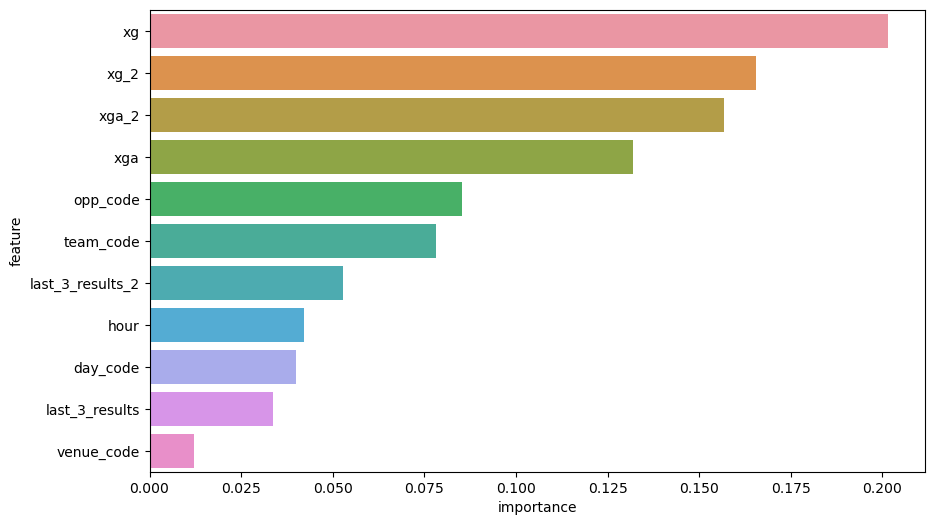

In [8]:
#create a bar plot to visualize the feature importance
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=rf_feature_importance.sort_values(by="importance", ascending=False))

In [9]:
# Generate classification report
print(classification_report(y_test, preds))


              precision    recall  f1-score   support

        -1.0       0.77      0.82      0.79       816
         1.0       0.67      0.60      0.63       494

    accuracy                           0.74      1310
   macro avg       0.72      0.71      0.71      1310
weighted avg       0.73      0.74      0.73      1310



### Gradient Boosting Classifer

In [10]:
# Initialize Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=1)
# Train Gradient Boosting Classifier on the training data
gb_model.fit(X_train, y_train)
# Predictions
gb_preds = gb_model.predict(X_test)
gb_preds_train = gb_model.predict(X_train)
# Reshape the gb_preds_train array
gb_preds_train = gb_preds_train.reshape(-1, 1)
# Reshape the gb_preds array
gb_preds = gb_preds.reshape(-1, 1)
# Evaluate the best model on the training set
boost_train_accuracy = gb_model.score(X_train, y_train)
print("Training Accuracy:", boost_train_accuracy)
# Evaluate the best model on the test set
boost_test_accuracy = gb_model.score(X_test, y_test)
print("Testing Accuracy:", boost_test_accuracy)

Training Accuracy: 0.762107329842932
Testing Accuracy: 0.749618320610687


In [12]:
# Create a contingency table showing the counts of actual versus predicted labels
gb_combined = pd.DataFrame({"actual": y_test, "prediction": gb_preds.reshape(-1)})
pd.crosstab(index=gb_combined["actual"], columns=gb_combined["prediction"])

prediction,-1.0,1.0
actual,,
-1.0,677,139
1.0,189,305


In [13]:
# determine which feature explains the most variance in the model
importances = gb_model.feature_importances_
# return the original feature names
feature_names = X.columns
#create a DataFrame to display the feature importance
feature_importance = pd.DataFrame({"feature": feature_names, "importance": importances})
feature_importance

,feature,importance
0,venue_code,0.001491
1,opp_code,0.036913
2,hour,0.004963
3,day_code,0.004794
4,team_code,0.047386
5,last_3_results,0.007603
6,last_3_results_2,0.021165
7,xg,0.319812
8,xga,0.153507
9,xg_2,0.171425


<Axes: xlabel='importance', ylabel='feature'>

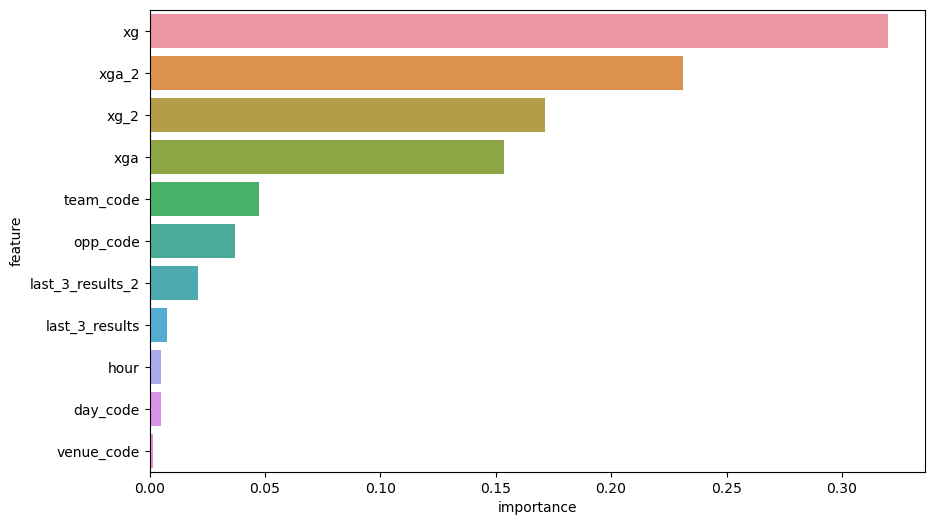

In [ ]:
#create a bar plot to visualize the feature importance
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=feature_importance.sort_values(by="importance", ascending=False))

In [14]:
# Generate classification report
print(classification_report(y_test, gb_preds))


              precision    recall  f1-score   support

        -1.0       0.78      0.83      0.80       816
         1.0       0.69      0.62      0.65       494

    accuracy                           0.75      1310
   macro avg       0.73      0.72      0.73      1310
weighted avg       0.75      0.75      0.75      1310

